In [2]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.optim as optim
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

In [3]:
df = pd.read_csv('MRK.csv')
df.shape

(1510, 7)

# Data Processing：
The data was downloaded from Yahoo Finance. It contains the price data of this stock from Jan 2, 2015 to Dec 31, 2020. The symbol is MRK.the value of the data is quite large, which is not good for training a neural network, so we scale them to make their mean equal to 0 and variance equal to 1.

<AxesSubplot:xlabel='Date'>

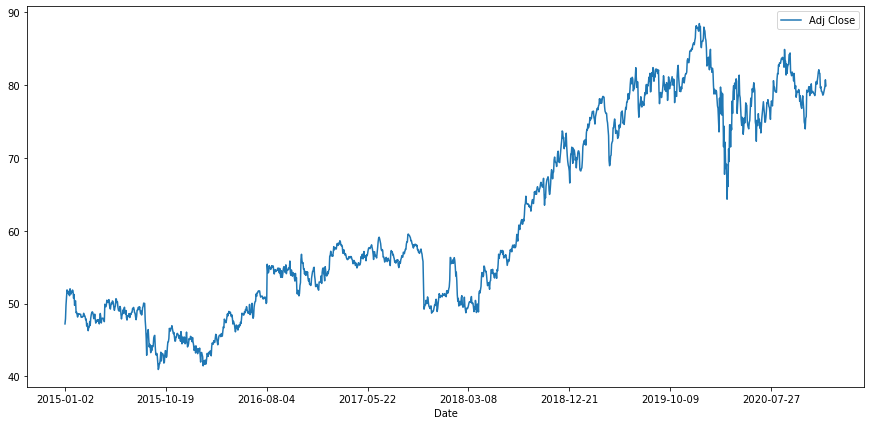

In [5]:
# plot adjusted close price with time

pricePath = np.array(df['Adj Close'])
df.plot(x="Date", y="Adj Close", figsize=(15, 7))

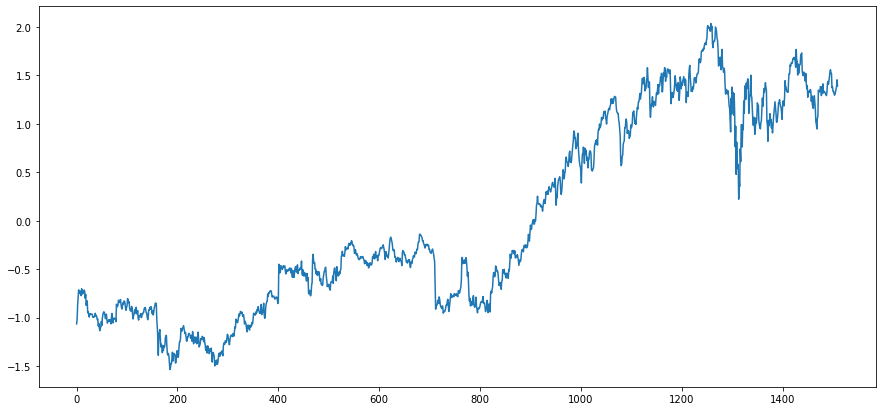

In [6]:

pricePathStd = (pricePath - np.mean(pricePath)) / np.std(pricePath)
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(pricePathStd)

As we used the formula:     𝑝=(𝑝−𝜇)/𝜎

process the data :
we are reforming the data format into the (input,output), then we set the dataforamt in this rule: we use the formal 15 datavaue to predict the 16th data. therefore the inout will be the value of the previous 15 data value, the output will be the 16th value of data.

In [7]:
window = 15
data = np.concatenate([pricePathStd[i: i+window+1].reshape(1, -1)
                       for i in range(len(pricePathStd)-window)], 0)
data.shape

(1495, 16)

now we separate the dataset as train and test, train part, as the reauqirement suggests we select the first 5years data as training set and the last year data as test set.

In [14]:
#this is the corresponding data
trainData = torch.from_numpy(data[0:1245]).float()
testData = torch.from_numpy(data[1245:]).float()

# this is the corresponding datasets & dataloaders we set the batch size as 256 in train set and 32 in test set.
trainset = Data.TensorDataset(trainData[:, 0:-1], trainData[:, -1:])# (input ,output)
testset = Data.TensorDataset(testData[:, 0:-1], testData[:, -1:])
trainloader = Data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=0)
testloader = Data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=0)
criterion = torch.nn.MSELoss()

# Models building:
the FNN network is like below:

In [23]:
class FNN_net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden1, n_hidden2, n_output):
        super(FNN_net, self).__init__()  # inherit methods from torch.nn.Module

        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # h1 layer
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)  # h2 layer
        self.output = torch.nn.Linear(n_hidden2, n_output)  # output layer
        self.n_feature = n_feature
   # max（0，x） 的激活函数
    def forward(self, x):
        x = torch.relu_(self.hidden1(x))
        x = torch.relu_(self.hidden2(x))
        x = self.output(x)
        return x 
def train(model, num_epoch, dataloader):
    # 一个epoch 是把整个数据跑一遍，定义为一个epoche，总共大约6个batch，最后一个小一点因为除不尽
    # SGD with momentum:
    # optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    # Adam:learning rate的变化策略
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_train_list = []  # record training loss
    for epoch in range(num_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        batch_num = 0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # print(inputs.shape, labels.shape)
            # zero the parameter gradients# 没有梯度下降learning rate
            optimizer.zero_grad()

            outputs = model(inputs)  # forward propagation, get outputs
            # print(outputs.squeeze())
            # print(labels.shape, outputs.shape)
            loss = criterion(outputs, labels)  # get loss
            loss.backward()  # back propagation, get gradients of loss # w=w - deltaloss/deltaw *learning rate anyway！正负不重要
            optimizer.step()  # optimize one step

            # record loss and other statistics
            running_loss += inputs.shape[0] * loss.item()# 乘数据的意义是。 loss.item()是每一个batch的256个数据的平均值，inputs shape0 = 多少组数据，shape=（256,11）除了最后一组
            batch_num += inputs.shape[0]#batch数据累计
        loss_train = running_loss / batch_num
        #把每一个batch的loss加在一起取平均
        
        loss_train_list.append(loss_train)
    print('Finished Training')
    return loss_train_list

# testset model is similiar as the training set, they share the similar logic.
def test(model, dataloader):
    with torch.no_grad():
        running_loss = 0.0
        batch_num = 0
        for i, data in enumerate(dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            outputs = model(inputs)  # forward propagation, get outputs
            loss = criterion(outputs, labels)  # get loss

            # record loss and other statistics
            running_loss += inputs.shape[0] * loss.item()
            batch_num += inputs.shape[0]
    return (running_loss / batch_num)

now we train the data

In [27]:
fnn = FNN_net(15, 30, 30, 1)


In [30]:
loss_fnn = train(fnn, 50, trainloader)

Finished Training


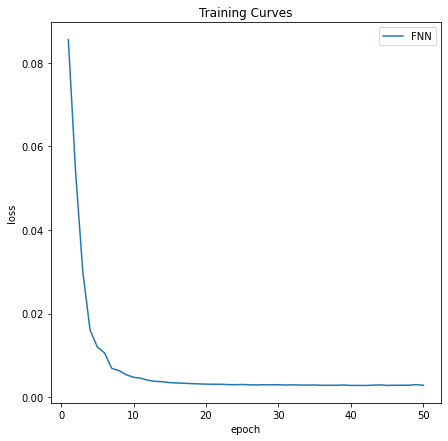

In [31]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(range(1, 1+len(loss_fnn)), loss_fnn, label="FNN")

ax.set_title("Training Curves")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()

the train loss is   0.00286  


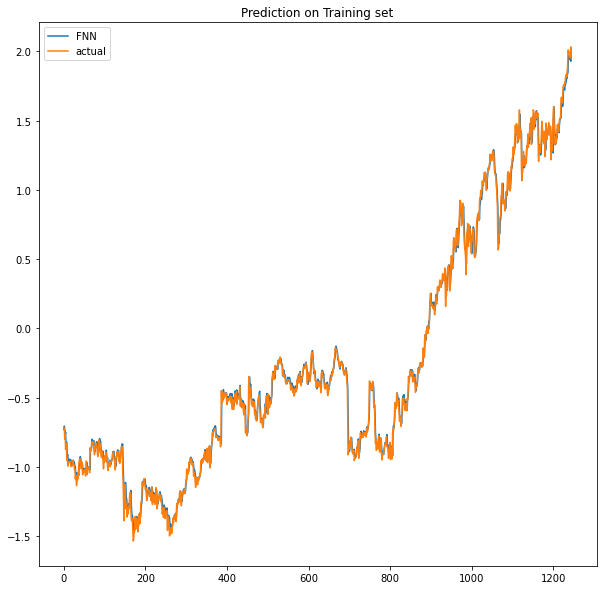

In [59]:
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.set_title("Prediction on Training set")
modelname = ["FNN"]
dataloader=trainloader
for i,j in enumerate([fnn]):
    ax1.plot(j(trainData[:, :-1])
             [:, ].squeeze().data.numpy(), label=modelname[i])
    
    print("the train loss is  %8.5f  " % ( test(j, trainloader)))

ax1.plot(trainData[:, -1], label="actual")
ax1.legend()

the test loss is    0.01278


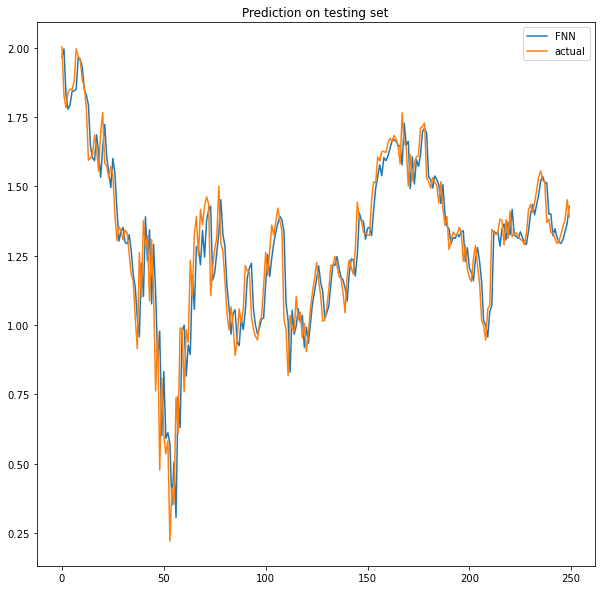

In [60]:
fig, ax2 = plt.subplots(figsize=(10, 10))
ax2.set_title("Prediction on testing set")
modelname = ["FNN"]
dataloader=testloader
for i,j in enumerate([fnn]):
    ax2.plot(j(testData[:, :-1])
             [:, ].squeeze().data.numpy(), label=modelname[i])
    
    print("the test loss is   %8.5f" % ( test(j, testloader)))

ax2.plot(testData[:, -1], label="actual")
ax2.legend()

the figure is as above and the training loss is 0.00286, the test loss is  0.01278